# Time-Series Prediction

## Imports

Import required libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)

# Import the plotting library
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model


from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


#### Load the data

In [2]:
#open the Excel file
xl = pd.ExcelFile("/Users/csstnns/Downloads/Dataset.xlsx")
#list sheet names
xl.sheet_names

['Dataset', 'LONAMS', 'Pivot']

In [3]:
#get the Dataset sheet
df = xl.parse("Dataset")
#view the first few rows of the data
df.head()

,itinerary,itinerary_from,hub,itinerary_to,equipment_1,equipment_2,itinerary_cityFrom,itinerary_cityTo,itinerary_dTimeDate,itinerary_dTimeHour,Morning_flights,Afternoon_flights,Evening_flights,Early_morning_flights,Late_evening_flights,Day_of_the_week,itinerary_aTimeUTC,itinerary_aTimeDate,itinerary_aTimeHour,connecting_time,tot_time (s),Flights_per_airlines,airline_1,airline_2,Tot_flights,Competition2,flight_no_1,flight_no_2,price,dbd,itinerary_dTimeUTC
0,0,AMS,NaN,SEN,NaN,NaN,Amsterdam,London,2019-10-12,10:30:00,Yes,No,No,No,No,Saturday,2019-10-12 11:30:00,2019-10-12,11:30:00,NaN,3600,24,U2,NaN,70,0.342857,7402,NaN,105,1,2019-10-12 10:30:00
1,1,AMS,NaN,STN,NaN,NaN,Amsterdam,London,2019-10-12,09:50:00,Yes,No,No,No,No,Saturday,2019-10-12 10:55:00,2019-10-12,10:55:00,NaN,3900,24,U2,NaN,70,0.342857,3002,NaN,134,1,2019-10-12 09:50:00
2,2,AMS,NaN,STN,NaN,NaN,Amsterdam,London,2019-10-12,17:40:00,No,Yes,No,No,No,Saturday,2019-10-12 18:45:00,2019-10-12,18:45:00,NaN,3900,24,U2,NaN,70,0.342857,3006,NaN,134,1,2019-10-12 17:40:00
3,3,AMS,NaN,STN,NaN,NaN,Amsterdam,London,2019-10-12,20:10:00,No,No,Yes,No,No,Saturday,2019-10-12 21:15:00,2019-10-12,21:15:00,NaN,3900,24,U2,NaN,70,0.342857,3004,NaN,134,1,2019-10-12 20:10:00
4,4,AMS,NaN,LTN,321,NaN,Amsterdam,London,2019-10-12,07:00:00,Yes,No,No,Yes,No,Saturday,2019-10-12 08:10:00,2019-10-12,08:10:00,NaN,4200,6,VK,NaN,70,0.085714,8404,NaN,61,1,2019-10-12 07:00:00


#### Get the Amsterdam to London data
Filter the data and keep only the Amsterdam -> London flight data

In [4]:
data = df[(df['itinerary_cityFrom'] == 'Amsterdam') & (df['itinerary_cityTo'] == 'London')].copy()
data.reset_index(drop=True, inplace=True)

#### Check data for missing values

In [5]:
data.isna().sum()

itinerary                   0
itinerary_from              0
hub                      6534
itinerary_to                0
equipment_1              3106
equipment_2              7553
itinerary_cityFrom          0
itinerary_cityTo            0
itinerary_dTimeDate         0
itinerary_dTimeHour         0
Morning_flights             0
Afternoon_flights           0
Evening_flights             0
Early_morning_flights       0
Late_evening_flights        0
Day_of_the_week             0
itinerary_aTimeUTC          0
itinerary_aTimeDate         0
itinerary_aTimeHour         0
connecting_time          6534
tot_time (s)                0
Flights_per_airlines        0
airline_1                   0
airline_2                6534
Tot_flights                 0
Competition2                0
flight_no_1                 0
flight_no_2              6534
price                       0
dbd                         0
itinerary_dTimeUTC          0
dtype: int64

#### Make the itinerary_dTimeUTC field as index .. and get the Price column too .. keep these two columns only

In [6]:
data = data[['price','itinerary_dTimeUTC']]

# sort by date
data.sort_values(by='itinerary_dTimeUTC', inplace=True)

# make the date column as index
data.set_index('itinerary_dTimeUTC', inplace=True)

In [7]:
#check how many rows and columns (should be one column only)
data.shape

(8278, 1)

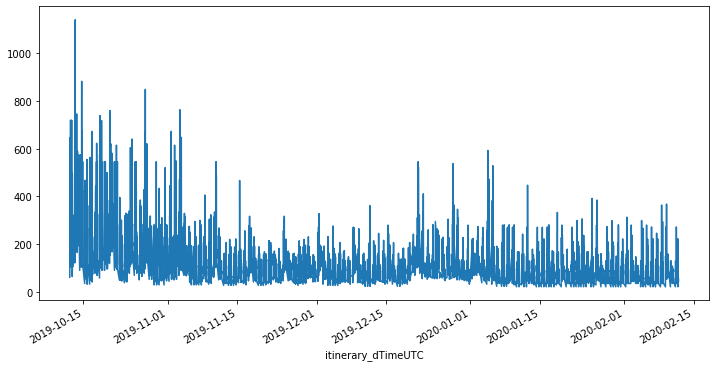

In [8]:
# Plot price over time
# Notice the fluctuations .. no clear pattern or trend in the data
data['price'].plot(figsize=(12, 6))

#### Split the Data into Train/test subsets

In [9]:
# let's use the first 8000 values for training and the rest for testing
# remember the data is ordered by time
train_size = 8000
train_df = data[:train_size]
print('train shape:', train_df.shape)
test_df = data[train_size:]
print('test shape: ',test_df.shape)

train shape: (8000, 1)
test shape:  (278, 1)


### Normalise the Data into values between 0 and 1

In [10]:
# After this step train and test will become numpy matrices instead of pandas dataframes
# NOTICE: we use the model that is fitted to the train data to scale the test data .. very important to do it this way!
x_scaler = MinMaxScaler()
train = x_scaler.fit_transform(train_df.values.reshape(-1, 1))
test = x_scaler.transform(test_df.values.reshape(-1, 1))

In [11]:
# make sure values are between 0-1
print("Min x:", np.min(train))
print("Max x:", np.max(train))

Min x: 0.0
Max x: 1.0


#### To Split Data into Sequences


In [12]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = [], []
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

#### Create sequences for training data

In [13]:
# choose a number of time steps
n_steps = 65
# split into samples
X_train, y_train = split_sequence(train, n_steps)

#### Create sequences for test data

In [14]:
# split into samples
X_test, y_test = split_sequence(test, n_steps)

#### Data Shape suitable for feeding into TF/Keras

In [15]:
print(X_train.shape)
print(X_test.shape)

(7935, 65, 1)
(213, 65, 1)


## Model Building and Fitting (RNN, LSTM and GRU)

In [ ]:
%%time
n_features = 1

# define model
model = Sequential()
#add one LSTM layer
model.add(LSTM(500))
#add one dense layer to predict the final outcome (i.e. the price)
model.add(Dense(1))
#prepare model (optimizer, loss etc)
model.compile(optimizer='adam', loss='mse')
# simple early stopping and model checkpoint
# stop training if the model does not improve for 5 consecutive epochs (patience=5)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# we save the model with the lowest value for 'validation loss'
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
# fit the model and keep track of loss for validation and training
history = model.fit(X_train, y_train, validation_split=0.1, epochs=10, batch_size=64, verbose=1)

Train on 7141 samples, validate on 794 samples
Epoch 1/10
6400/7141 [=========================>....] - ETA: 11s - loss: 0.0044

### Summarize history for loss

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Load the saved best model

In [ ]:
# load the saved model
model = load_model('best_model.h5')

In [ ]:
#X_test[0].shape
#model.evaluate(X_test, y_test)

#### Compute RMSE for Evaluation

In [ ]:
def rmse(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred - y_true))) 

#### Predict the test set

In [ ]:
preds = np.zeros(len(y_test))

# demonstrate predictions
for i in range(X_test.shape[0]):
    x_input = X_test[i]
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    preds[i] = (yhat[0])

### After getting the predictions we need to transform the predicted and actual Y values into their original range
### Remember we applied scaling previously

In [ ]:
# The output of the model is between 0 and 1.
# Do an inverse map to get it back to the scale of the original dataset
preds_ = x_scaler.inverse_transform((preds.reshape(-1,1)))
# we also rescale the y_test values into their original range (inverse scaling)
actuals = x_scaler.inverse_transform(y_test)

### Compute RMSE on the test set

In [ ]:
rmse(actuals, preds_)

#### Plot True vs Predicted

In [ ]:
# multiple line plot
plt.plot(actuals, marker='o', label='True')
plt.plot(preds, marker='*', label='Predicted')

plt.legend()